In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(param, x):
        
    window = param['window']
    step_size = param['step_size']
        
    times = x[0]
    i_ion = x[1]
              
    i_ion_window = []
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)            
        I_window = i_ion[start_index: end_index + 1]                                    
        i_ion_window.append(sum(I_window)/len(I_window))            
        t += step_size
            
    return i_ion_window

In [3]:
# def get_currents_with_constant_dt(sol, window=1, step_size=1):
    
#     times = sol['Time'].values
#     currents = sol.drop(['Time'], axis=1)
    
#     avg_currents = collections.defaultdict(list)
#     t = 0
#     while t <= times[-1] - window:
#         start_index = find_closest_index(times, t)
#         end_index = find_closest_index(times, t + window)
#         currents_in_window = currents[start_index: end_index + 1]

#         window_avg_currents = {}               
#         for name in currents.columns:                 
#             window_avg_currents[name] = currents_in_window[name].sum()/len(currents_in_window[name])    
#             # window_avg_currents[name] = currents_in_window[name].min()
#             # window_avg_currents[name] = currents_in_window[name].max()

#         avg_currents['Time Start'].append(t)
#         avg_currents['Time End'].append(t + window)
#         avg_currents['Time Mid'].append((2*t + window)/2)

#         for key, val in window_avg_currents.items():     
#             # print(key, val)
#             avg_currents[key].append(val)
#         t += step_size
        
#     return avg_currents

In [4]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

The protocol is 15.4 s


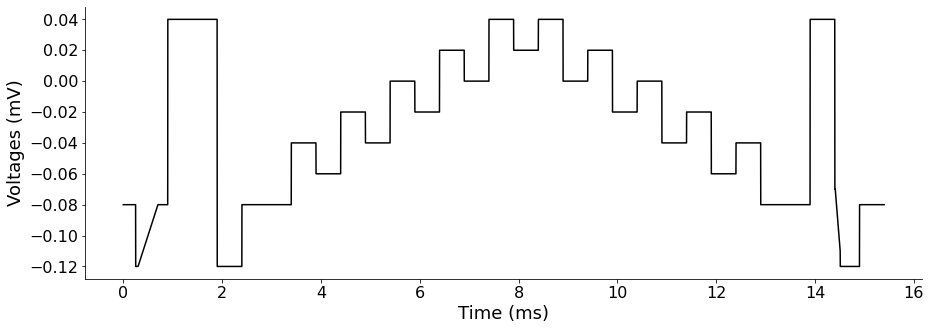

In [5]:
'''
leak_staircase
'''
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')
VC_protocol.plot_voltage_clamp_protocol(t_eval)

In [17]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],   
    't_eval' : t_eval, 
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],
    'nData' : 5,                         
    # 'dataset_dir' : '../../Dataset/ohara2017_LeemV1',
    'dataset_dir' : f'../../Dataset/herg25oc1_real_data',
    'data_file_name' : 'IKr',
    'window' : 10,
    'step_size' : 5,
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )

sys.path.append(gen_params['dataset_dir'])
from getdata import get_dataset, get_times

../../Dataset/herg25oc1_real_data


In [18]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=1, multi=True, torch_tensor=False)  # <-- fast

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211


In [19]:
print(xs.shape, ys.shape)

(211, 77000) (211, 9)


In [22]:
dataNo = 100

sol1 = {}
sol1['Time'] = get_times(scale=1)
sol1["IKr"] = xs[dataNo]
y = ys[dataNo]

# sol1 = pd.DataFrame(data=sol1)
# sol1.head()

In [37]:
np.std(sol1["IKr"][:1000])

10.53860679255264

In [24]:
print(sol1['Time'].shape, sol1["IKr"].shape)

(77000,) (77000,)


In [25]:
y

array([5.65246434e+04, 1.09827235e-01, 9.10730308e+01, 6.66694679e-02,
       3.55734178e+01, 6.56912022e+01, 3.31502009e+01, 1.13545248e+01,
       2.90442393e+01])

In [26]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1e-3, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.6773254871368408 seconds ---


In [27]:
start_time = time.time()

model_params = {                    
    'ikr.g' : y[0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
    'ikr.p1' : y[1],
    'ikr.p2' : y[2],
    'ikr.p3' : y[3],
    'ikr.p4' : y[4],
    'ikr.p5' : y[5],
    'ikr.p6' : y[6],
    'ikr.p7' : y[7],
    'ikr.p8' : y[8],                
} 
sim.set_simulation_params(model_params)                
    
sim.pre_simulate(100, sim_type=1)
# d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           
d = sim.simulate( gen_params['end_time'], log_times=None, extra_log=gen_params['log_li'])                           
              
sol2 = {}
sol2["Time"] = d['engine.time']
sol2["IKr"] = d['ikr.IKr'] #+ np.random.normal(0, 2, d['membrane.i_ion'].shape) # add noise
sol2["open"] = d['ikr.open']
sol2["active"] = d['ikr.open']
sol2["params"] = y
# sol2 = pd.DataFrame(data=sol2)
# sol2.head()
# np.random.normal(0, noise_sigma, current.shape) # add noise
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.389986515045166 seconds ---


In [28]:
# sol2 = get_currents_with_constant_dt(sol2, window=gen_params['window'], step_size=gen_params['step_size'])

In [29]:
sol2["IKr"].shape

(24660,)

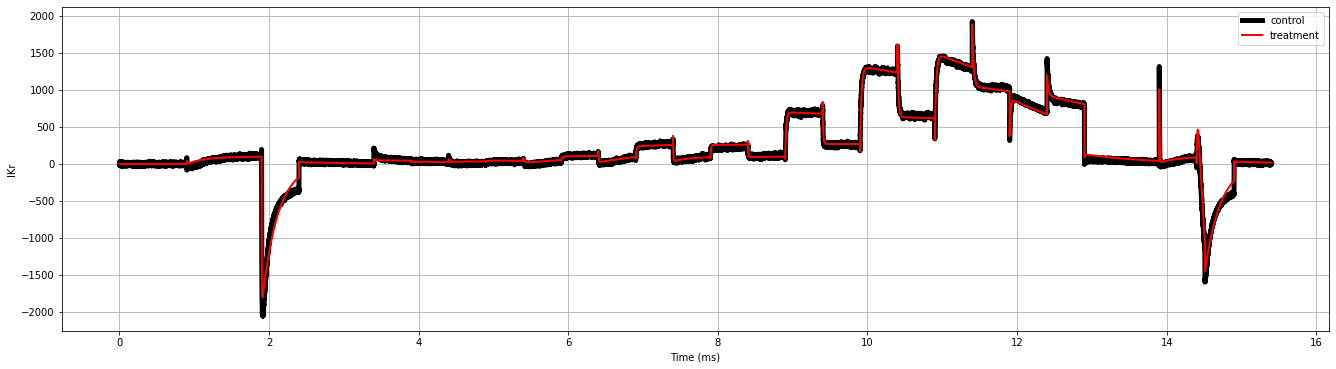

In [40]:
'''
Plot
'''
fig, ax = plt.subplots(1,1, figsize=(20,5))    
# fig.suptitle(sim.name, fontsize=14)
axNo = 0
for name in ['IKr']:    
    # if name!='Time Start' and name!='Time End' and name!='Time Mid':
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (ms)')       
    ax.set_ylabel(f'{name}')      
    ax.plot( sol1["Time"], sol1[name], label='control', color='k', linewidth=5)     
    ax.plot( sol2["Time"], sol2[name], label='treatment', color='r', linewidth=2)    
    ax.legend()
    ax.grid()
    axNo += 1

# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)